# Plot reduction over simulations (from pixel and Gaussian)


This script loads the results of simulations produced by 'launch_RNN_simulations.ipynb'. This package contains the results of several runs and so it is not necessary to run launch_RNN_simulations.

In [1]:
import submitit
import os
import numpy as np
import matplotlib.pyplot as plt

from run_RNN_pixel_simulation import run_rnn
from reduction import compute_timecourse_zpolicy, descriptive_zpol

## Load and collate simulation results

Folder paths may need to be adjusted depending on where results from launch_RNN_simulations have been saved.

In [8]:
# Load and collate Gaussian results
data_type = 'gauss'
dt = .0005
lr = .1
gamma = .01
alpha = .05

expt_folder = f"rnn_sim_res2_{data_type}_lr_{lr}_dt{dt}_gam{gamma}_al{alpha}"


jobnames = []
for rep in range(50):
    exptname = f"{expt_folder}/exp{rep}"
    jobnames.append(exptname)

def unpack(metric, ds):
    return np.hstack([d[metric] for d in ds])

ds = [np.load(f"{j}.npz") for j in jobnames]

time_g = unpack('time', ds)
DT_g = unpack('DT', ds)
e_history_g = unpack('e_history', ds)
TT_g = unpack('TT', ds)
w_history_g = unpack('w_history', ds)
z_g = unpack('z', ds)

dt = ds[0]['dt']
co = ds[0]['co']
Ntrials = ds[0]['Ntrials']
#lr = ds[0]['lr']
gamma = ds[0]['gamma']
DT_target = ds[0]['DT_target']
z0 = ds[0]['z0']
w0 = ds[0]['w0']

D = 6.370
Dp = 3.136-D
T0 = .16

In [9]:
# Load and collate results
data_type = 'blob'
dt = .0005
lr = .1
gamma = .01
alpha = .05
blob_scale = 50.

expt_folder = f"rnn_sim_res2_{data_type}_lr_{lr}_bs_{blob_scale}_dt{dt}_gam{gamma}_al{alpha}"


jobnames = []
for rep in range(10):
    exptname = f"{expt_folder}/exp{rep}"
    jobnames.append(exptname)

def unpack(metric, ds):
    return np.hstack([d[metric] for d in ds])

ds = [np.load(f"{j}.npz") for j in jobnames]

time = unpack('time', ds)
DT = unpack('DT', ds)
e_history = unpack('e_history', ds)
TT = unpack('TT', ds)
w_history = unpack('w_history', ds)
z = unpack('z', ds)

dt = ds[0]['dt']
co = ds[0]['co']
Ntrials = ds[0]['Ntrials']
#lr = ds[0]['lr']
gamma = ds[0]['gamma']
DT_target = ds[0]['DT_target']
z0 = ds[0]['z0']
w0 = ds[0]['w0']

D = 6.370
Dp = 3.136-D
T0 = .16

In [11]:
# Append more results (the following code allows combining results across multiple folders)
data_type = 'blob'
dt = .0005
lr = .1
gamma = .01
alpha = .05
blob_scale = 50.

expt_folder = f"rnn_sim_res_{data_type}_lr_{lr}_bs_{blob_scale}_dt{dt}_gam{gamma}_al{alpha}"


jobnames = []
for rep in range(10):
    exptname = f"{expt_folder}/exp{rep}"
    jobnames.append(exptname)

def unpack(metric, ds):
    return np.hstack([d[metric] for d in ds])

ds = [np.load(f"{j}.npz") for j in jobnames]

time2 = unpack('time', ds)
DT2 = unpack('DT', ds)
e_history2 = unpack('e_history', ds)
TT2 = unpack('TT', ds)
w_history2 = unpack('w_history', ds)
z2 = unpack('z', ds)

time = np.hstack((time, time2[0:Ntrials,:]))
DT = np.hstack((DT, DT2[0:Ntrials,:]))
e_history = np.hstack((e_history, e_history2[0:Ntrials,:]))
TT = np.hstack((TT, TT2[0:Ntrials,:]))
w_history = np.hstack((w_history, w_history2[0:Ntrials,:]))
z = np.hstack((z, z2[0:Ntrials+1,:]))

## Plot simulations overlaid with theory curves

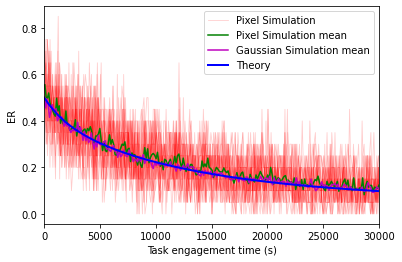

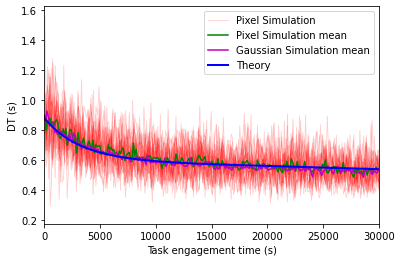

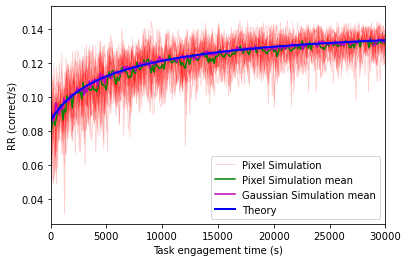

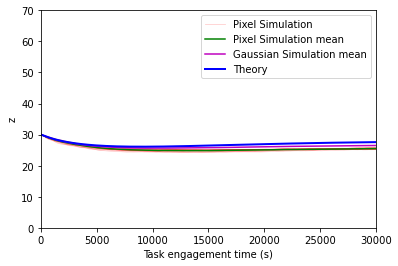

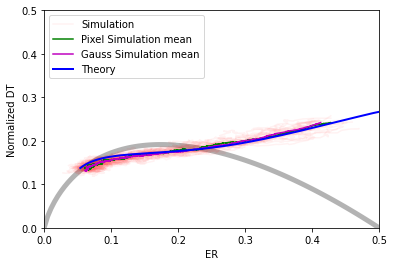

In [12]:
# Learning parameters
Ntrials = 10000
lr=.1
gamma = .01
alpha=.05

z0 = 30.
w0 = .0001

# Dataset parameters
co = 32

# For theory only
A = .82
ci = .01


w_a = np.zeros(Ntrials)
w_a[0] = w0
zbar_a = np.zeros(Ntrials)
SNR_a = np.zeros(Ntrials)
ER_a = np.zeros(Ntrials)
ER_est = np.zeros(Ntrials)
DT_a = np.zeros(Ntrials)
TT_a = np.zeros(Ntrials)
RR_a = np.zeros(Ntrials)
xev_a = np.zeros(Ntrials)
trade_a = np.zeros(Ntrials)
z_a = np.zeros(Ntrials)
z_a[0] = z0

# Run forward theory prediction
for trial in range(Ntrials):
    zbar_a[trial] = z_a[trial]/(A*w_a[trial])
    SNR_a[trial] =  A**2*w_a[trial]**2/(ci**2*w_a[trial]**2 + co**2)
    ER_a[trial] = 1/(1 + np.exp(2*zbar_a[trial]*SNR_a[trial]))
    DT_a[trial] = zbar_a[trial]*np.tanh(zbar_a[trial]*SNR_a[trial])
    TT_a[trial] = DT_a[trial] + D + T0 + Dp*ER_a[trial]
    RR_a[trial] = (1-ER_a[trial])/(DT_a[trial] + D + T0 + Dp*ER_a[trial])
    
    if trial > 0:
        ER_est[trial] = (1-alpha)*ER_est[trial-1] + alpha*ER_a[trial]
    else:
        ER_est[trial] = .45
    
    
    DT_target = (1/(1/( ER_est[trial]*np.log( (1-ER_est[trial])/ER_est[trial] ) ) + 1/ (1 - 2*ER_est[trial]) ))*(D + Dp + T0)
    
    if trial < Ntrials-1:
        w_a[trial+1] = w_a[trial] + lr*ER_a[trial]*( (A*DT_a[trial]) + 1./(1+co**2/(w_a[trial]**2*ci**2))*(-z_a[trial]/w_a[trial] - A*DT_a[trial]))
        z_a[trial+1] = z_a[trial] + gamma*(DT_target - DT_a[trial])

    xev_a = A*DT_a[trial]
    trade_a[trial] = 1./(1+co**2/(w_a[trial]**2*ci**2))
        
time_a = np.cumsum(TT_a) 
rep_alpha = .2
subsample_factor = 20

subsamp = lambda x: x[::subsample_factor,:]
subsamp1 = lambda x: x[::subsample_factor]

def moving_average(a, n=100):
    ret = np.cumsum(a, axis=0, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_avg(time,quant,time_g,quant_g,time_a,quant_a):
    plt.plot(time[:,0],quant[:,0],color='r',alpha=rep_alpha,linewidth=.8,label='Pixel Simulation')
    plt.plot(time[:,1:],quant[:,1:],color='r',alpha=rep_alpha,linewidth=.8,label='_Simulation')
    plt.plot(np.mean(time,axis=1),np.mean(quant,axis=1),color='g',label='Pixel Simulation mean')
    #plt.plot(time_g[:,0],quant_g[:,0],color='g',alpha=rep_alpha,linewidth=.8,label='_Gauss Simulation')
    #plt.plot(time_g[:,1:],quant_g[:,1:],color='g',alpha=rep_alpha,linewidth=.8,label='_Gauss Simulation')
    plt.plot(np.mean(time_g,axis=1),np.mean(quant_g,axis=1),color='m',label='Gaussian Simulation mean')
    plt.plot(time_a,quant_a,color='b',linewidth=2,label='Theory')
    plt.xlim((0,30000))
    
window = 20
atime = moving_average(time,window) 
ER = moving_average(e_history,window)
aDT = moving_average(DT,window)
#time_a = moving_average(time_a,window)
#ER_a = moving_average(ER_a,window)
#DT_a = moving_average(DT_a,window)
#RR_a = moving_average(RR_a,window)
#z_a = moving_average(z_a,window)

ER_g = moving_average(e_history_g,window)
aDT_g = moving_average(DT_g,window)

# Plot comparisons
    
plot_avg(subsamp(atime),subsamp(ER),subsamp(time_g),subsamp(ER_g),subsamp1(time_a),subsamp1(ER_a))
plt.xlabel('Task engagement time (s)')
plt.ylabel('ER')
plt.legend()
plt.savefig('figs/er_dyn_comparison_rnn_pixels_final.pdf')
plt.show()

plot_avg(subsamp(atime),subsamp(aDT),subsamp(time_g),subsamp(aDT_g),subsamp1(time_a),subsamp1(DT_a))
plt.xlabel('Task engagement time (s)')
plt.ylabel('DT (s)')
plt.legend()
plt.savefig('figs/dt_dyn_comparison_rnn_pixels_final.pdf')
plt.show()

plot_avg(subsamp(atime),subsamp((1-ER)/moving_average(TT,window)),subsamp(time_g),subsamp((1-ER_g)/moving_average(TT_g,window)),subsamp1(time_a),subsamp1(RR_a))
plt.xlabel('Task engagement time (s)')
plt.ylabel('RR (correct/s)')
plt.legend()
plt.savefig('figs/rr_dyn_comparison_rnn_pixels_final.pdf')
plt.show()

plot_avg(subsamp(time),subsamp(z[:-1,:]),subsamp(time),subsamp(z_g[:-1,:]),subsamp1(time_a),subsamp1(z_a))
plt.xlabel('Task engagement time (s)')
plt.ylabel('z')
plt.ylim((0,70))
plt.legend()
plt.savefig('figs/z_dyn_comparison_rnn_pixels_final.pdf')
plt.show()

rep_alpha = .05
subsample_factor = 20

subsamp = lambda x: x[::subsample_factor,:]
subsamp1 = lambda x: x[::subsample_factor]

# Plot opc results
ER_vec = np.linspace(0.0001,.5-.0001,100)
Dnorm_opc = 1/(1/( ER_vec*np.log( (1-ER_vec)/ER_vec ) ) + 1/ (1 - 2*ER_vec) )
plt.plot(ER_vec,Dnorm_opc,color=(.7, .7, .7),linewidth=5)

window = 500
ER = moving_average(e_history,window)
aDT = moving_average(DT,window)
ER_g = moving_average(e_history_g,window)
aDT_g = moving_average(DT_g,window)

plt.plot(ER[::subsample_factor,0],aDT[::subsample_factor,0]/(D+Dp+T0),color='r',alpha=rep_alpha,label='Simulation')
plt.plot(ER[::subsample_factor,1:],aDT[::subsample_factor,1:]/(D+Dp+T0),color='r',alpha=rep_alpha,label='_Simulation')
plt.plot(np.mean(ER,axis=1),np.mean(aDT/(D+Dp+T0),axis=1),color='g',label='Pixel Simulation mean')
plt.plot(np.mean(ER_g,axis=1),np.mean(aDT_g/(D+Dp+T0),axis=1),color='m',label='Gauss Simulation mean')
plt.plot(subsamp1(ER_a),subsamp1((DT_a)/(D+Dp+T0)),color='b',linewidth=2,label='Theory')
plt.xlim((0,.5))
plt.ylim((0,.5))

plt.xlabel('ER')
plt.ylabel('Normalized DT')
plt.legend(loc='upper left')
plt.savefig('figs/opc_dyn_comparison_rnn_pixels_final.pdf')

## Code for fitting theory parameters to data or simulation runs

Fits can be performed with gradient descent or via grid search.

0


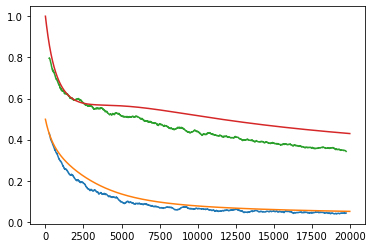

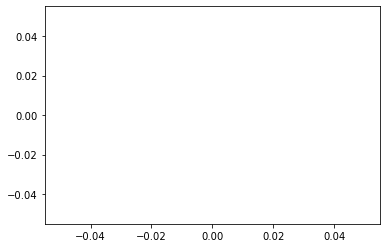

cost: 10.35 w0: 0.1 A: 0.651 co: 30 ci: 0.0997 z0: 30 alpha: 0.1 gamma: 0.01 lr: 0.1
1
2


KeyboardInterrupt: 

In [10]:
# Optimize unknown theory parameters to fit simulation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# Collate target trajectory to fit
subsample_factor = 10
acceleration_factor = 10

subsamp = lambda x: x[::subsample_factor,:]
subsamp1 = lambda x: x[::subsample_factor]

trialstarg = np.round(subsamp1(moving_average(np.arange(Ntrials),window)))
DTtarg = subsamp1(np.mean(aDT,axis=1))
ERtarg = subsamp1(np.mean(ER,axis=1))
ztarg = subsamp1(np.mean(z[:-1,:],axis=1))

# Hyperparameters to be inferred (probably some are redundant at present)

A =  Variable(.65*torch.ones(1), requires_grad = True)
ci = Variable(0.1*torch.ones(1), requires_grad = True)
co = Variable(30*torch.ones(1), requires_grad = True)
w0 = Variable(.1*torch.ones(1), requires_grad = True)
z0 = Variable(30*torch.ones(1), requires_grad = False)
lr = Variable(.1*torch.ones(1), requires_grad = False)
gamma = Variable(0.01*torch.ones(1), requires_grad = False)
alpha = 0.1
ER_est0 = Variable(.45*torch.ones(1), requires_grad=True)


Ntrials_a = int(np.round(Ntrials/acceleration_factor))
trials_a = np.round(np.arange(Ntrials_a)*acceleration_factor).astype(int)

zbar_a = [Variable(torch.ones(1), requires_grad = False) for t in np.arange(Ntrials_a)]
SNR_a = [Variable(torch.zeros(1), requires_grad = False) for t in np.arange(Ntrials_a)]
ER_a  = [Variable(torch.zeros(1), requires_grad = False) for t in np.arange(Ntrials_a)]
ER_est  = [Variable(ER_est0*torch.ones(1), requires_grad = False) for t in np.arange(Ntrials_a)]
DT_a  = [Variable(torch.zeros(1), requires_grad = False) for t in np.arange(Ntrials_a)]
TT_a  = [Variable(torch.zeros(1), requires_grad = False) for t in np.arange(Ntrials_a)]
RR_a  = [Variable(torch.zeros(1), requires_grad = False) for t in np.arange(Ntrials_a)]
w_a   = [Variable(w0*torch.ones(1), requires_grad = False) for t in np.arange(Ntrials_a)]
z_a   = [Variable(z0*torch.ones(1), requires_grad = False) for t in np.arange(Ntrials_a)]
DT_target  = [Variable(torch.zeros(1), requires_grad = False) for t in np.arange(Ntrials_a)]

Nitr = 100000 # Number of optimization steps

optimizer = optim.SGD([A,ci,co,w0,z0,lr,gamma], lr=.000005, momentum=.9)

Rtot_hist = np.zeros(Nitr)
ER_fit_hist = np.zeros(Nitr)
DT_fit_hist = np.zeros(Nitr)
cost_hist = np.zeros(Nitr)

for b in range(Nitr):
    print(b)
    optimizer.zero_grad()
    
    # Run forward theory prediction
    for trial in range(Ntrials_a):
        zbar_a[trial] = z_a[trial]/(A*w_a[trial])
        SNR_a[trial] =  A**2*w_a[trial]**2/(ci**2*w_a[trial]**2 + co**2)#A**2/(ci**2 + co**2/(u[t]**2))
        ER_a[trial] = 1/(1 + torch.exp(2*zbar_a[trial]*SNR_a[trial]))
        DT_a[trial] = zbar_a[trial]*torch.tanh(zbar_a[trial]*SNR_a[trial])
        TT_a[trial] = DT_a[trial] + D + T0 + Dp*ER_a[trial]
        RR_a[trial] = (1-ER_a[trial])/(DT_a[trial] + D + T0 + Dp*ER_a[trial])

        if trial > 0:
            ER_est[trial] = (1-acceleration_factor*alpha)*ER_est[trial-1] + acceleration_factor*alpha*ER_a[trial]
        
            

        #DT_target = (1/(1/( ER_a[trial]*np.log( (1-ER_a[trial])/ER_a[trial] ) ) + 1/ (1 - 2*ER_a[trial]) ))*(D + Dp + T0)
        DT_target[trial] = (1/(1/( ER_est[trial]*torch.log( (1-ER_est[trial])/ER_est[trial] ) ) + 1/ (1 - 2*ER_est[trial]) ))*(D + Dp + T0)

        if trial < Ntrials_a-1:
            w_a[trial+1] = w_a[trial] + acceleration_factor*lr*ER_a[trial]*( (A*DT_a[trial]) + 1./(1+co**2/(w_a[trial]**2*ci**2))*(-z_a[trial]/w_a[trial] - A*DT_a[trial]))
            z_a[trial+1] = z_a[trial] + acceleration_factor*gamma*(DT_target[trial] - DT_a[trial])



    ER_fit = 0
    DT_fit = 0
    for i,s in enumerate(trialstarg):

        ER_fit = ER_fit + (torch.Tensor([ERtarg[i]]) - ER_a[int(s/acceleration_factor)])**2
        DT_fit = DT_fit + (torch.Tensor([DTtarg[i]]) - DT_a[int(s/acceleration_factor)])**2

    cost = ER_fit + DT_fit
    
   
    ER_fit_hist[b] = ER_fit.data.numpy()
    DT_fit_hist[b] = DT_fit.data.numpy()
    cost_hist[b] = cost.data.numpy()

    cost.backward()
    optimizer.step()
    
    

    if np.mod(b,20)==0:
        plt.plot(trialstarg,ERtarg,trials_a,numpify(ER_a),trialstarg,DTtarg,trials_a,numpify(DT_a))
        plt.show()
        plt.plot(cost_hist[0:b])
        plt.show()
        print(f"cost: {cost.detach().numpy()[0]:.4g} w0: {w0.detach().numpy()[0]:.3g} A: {A.detach().numpy()[0]:.3g} co: {co.detach().numpy()[0]:.3g} ci: {ci.detach().numpy()[0]:.3g} z0: {z0.detach().numpy()[0]:.3g} alpha: {alpha:.2g} gamma: {gamma.detach().numpy()[0]:.2g} lr: {lr.detach().numpy()[0]:.2g}")
                            

In [14]:
def simulate_trace(Ntrials,w0,A,co,ci,z0,alpha,gamma,lr,DT_inflation):


    w_a = np.zeros(Ntrials)
    w_a[0] = w0
    zbar_a = np.zeros(Ntrials)
    SNR_a = np.zeros(Ntrials)
    ER_a = np.zeros(Ntrials)
    ER_est = np.zeros(Ntrials)
    DT_a = np.zeros(Ntrials)
    #TT_a = np.zeros(Ntrials)
    #RR_a = np.zeros(Ntrials)
    z_a = np.zeros(Ntrials)
    z_a[0] = z0

    trials_a = np.arange(Ntrials)
    # Run forward theory prediction
    for trial in range(Ntrials):
        zbar_a[trial] = z_a[trial]/(A*w_a[trial])
        SNR_a[trial] =  A**2*w_a[trial]**2/(ci**2*w_a[trial]**2 + co**2)#A**2/(ci**2 + co**2/(u[t]**2))
        ER_a[trial] = 1/(1 + np.exp(2*zbar_a[trial]*SNR_a[trial]))
        DT_a[trial] = zbar_a[trial]*np.tanh(zbar_a[trial]*SNR_a[trial])+DT_inflation
        TT_a[trial] = DT_a[trial] + D + T0 + Dp*ER_a[trial]
        #RR_a[trial] = (1-ER_a[trial])/(DT_a[trial] + D + T0 + Dp*ER_a[trial])

        if trial > 0:
            ER_est[trial] = (1-alpha)*ER_est[trial-1] + alpha*ER_a[trial]
        else:
            ER_est[trial] = .45

        #DT_target = (1/(1/( ER_a[trial]*np.log( (1-ER_a[trial])/ER_a[trial] ) ) + 1/ (1 - 2*ER_a[trial]) ))*(D + Dp + T0)
        DT_target = (1/(1/( ER_est[trial]*np.log( (1-ER_est[trial])/ER_est[trial] ) ) + 1/ (1 - 2*ER_est[trial]) ))*(D + Dp + T0)

        if trial < Ntrials-1:
            w_a[trial+1] = w_a[trial] + lr*ER_a[trial]*( (A*DT_a[trial]) + 1./(1+co**2/(w_a[trial]**2*ci**2))*(-z_a[trial]/w_a[trial] - A*DT_a[trial]))
            z_a[trial+1] = z_a[trial] + gamma*(DT_target - DT_a[trial])
    return ER_a, DT_a


itr 0 of 4000 (0% complete) 
error: 9.9 w0: 0.01 A: 0.5 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


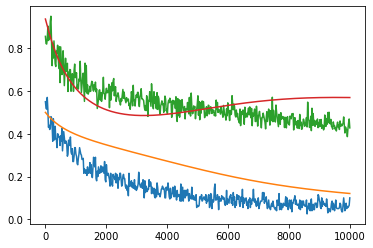

error: 7.9 w0: 0.01 A: 0.53 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


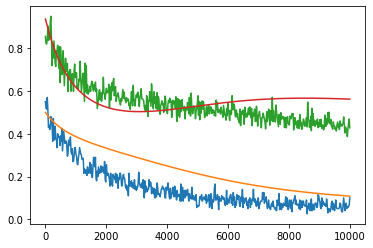

error: 6.2 w0: 0.01 A: 0.55 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


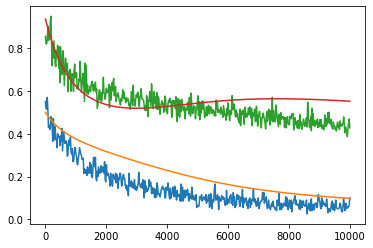

error: 4.9 w0: 0.01 A: 0.58 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


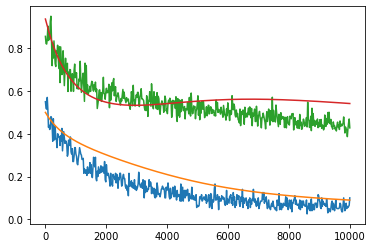

error: 3.9 w0: 0.01 A: 0.61 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


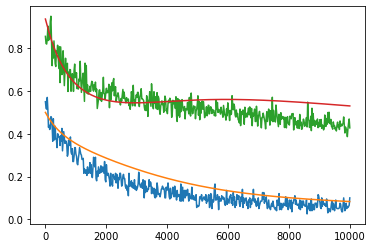

error: 3 w0: 0.01 A: 0.63 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


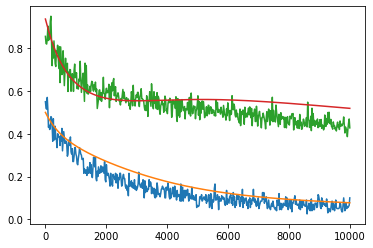

error: 2.4 w0: 0.01 A: 0.66 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


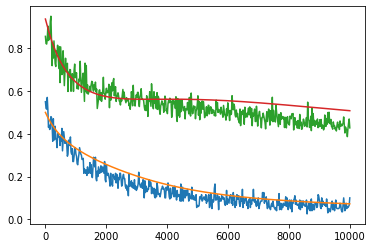

error: 1.9 w0: 0.01 A: 0.68 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


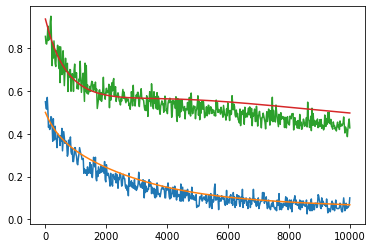

error: 1.5 w0: 0.01 A: 0.71 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


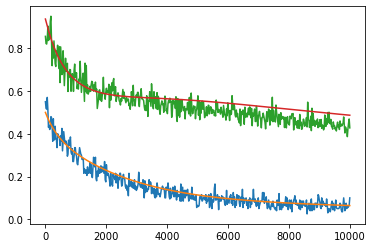

error: 1.3 w0: 0.01 A: 0.74 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


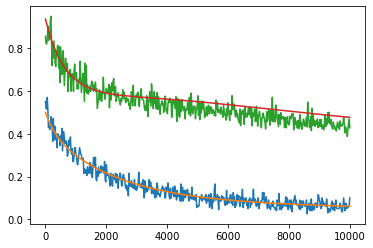

error: 1.1 w0: 0.01 A: 0.76 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


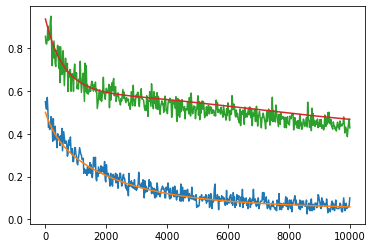

error: 1.1 w0: 0.01 A: 0.79 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


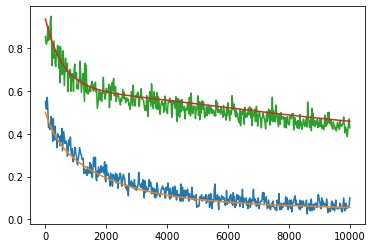

itr 400 of 4000 (10% complete) 
error: 1 w0: 0.01 A: 0.79 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


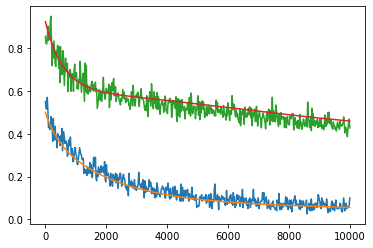

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


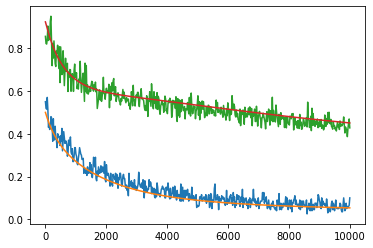

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.014 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


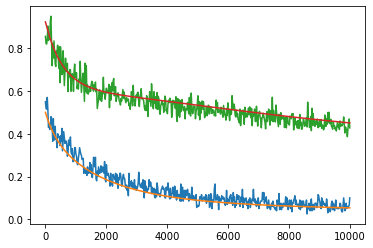

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.021 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


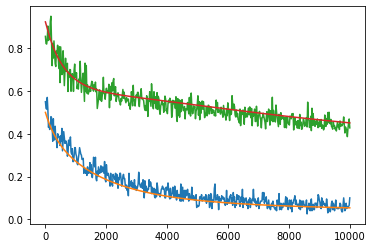

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.03 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


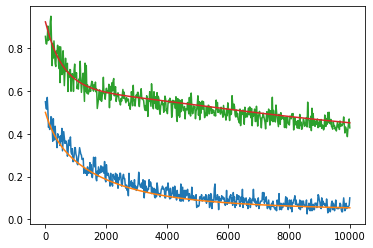

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.043 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


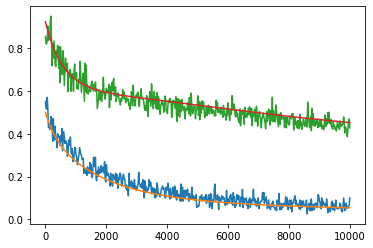

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.062 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


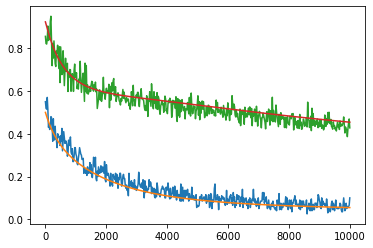

itr 800 of 4000 (20% complete) 
error: 1 w0: 0.01 A: 0.79 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


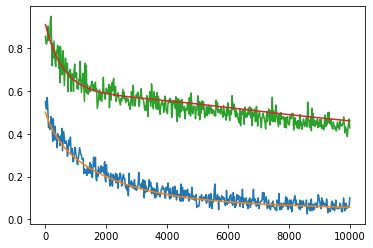

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


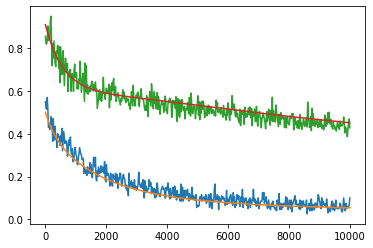

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.014 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


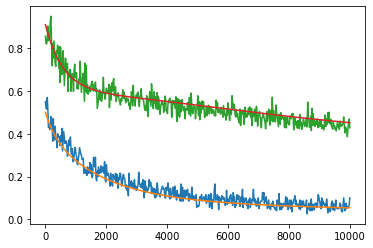

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.021 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


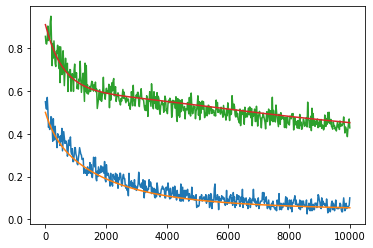

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.03 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


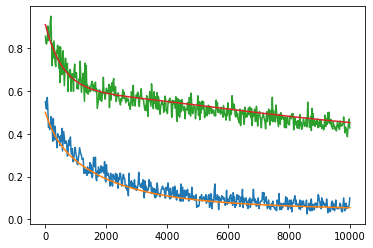

error: 1 w0: 0.01 A: 0.82 co: 31 ci: 0.043 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


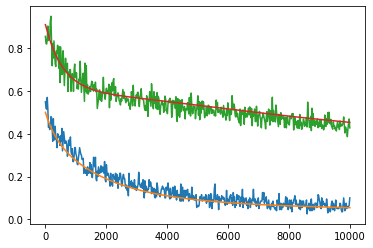

itr 1200 of 4000 (30% complete) 
error: 0.99 w0: 0.01 A: 0.82 co: 32 ci: 0.01 z0: 30 alpha: 0.05 gamma: 0.01 lr: 0.1 z0: 30 DT infl: 0


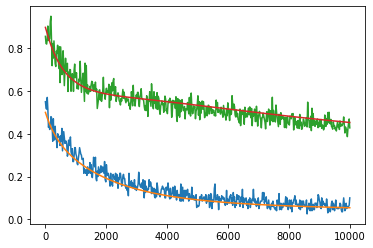

itr 1600 of 4000 (40% complete) 
itr 2000 of 4000 (50% complete) 
itr 2400 of 4000 (60% complete) 
itr 2800 of 4000 (70% complete) 
itr 3200 of 4000 (80% complete) 
itr 3600 of 4000 (90% complete) 


In [92]:
# Optimize unknown theory parameters to fit simulation via gridsearch

window = 10
ER = moving_average(e_history,window)
aDT = moving_average(DT,window)

trialstarg = np.round(subsamp1(moving_average(np.arange(Ntrials),window))).astype(int)
DTtarg = subsamp1(np.mean(aDT,axis=1))
ERtarg = subsamp1(np.mean(ER,axis=1))
ztarg = subsamp1(np.mean(z[:-1,:],axis=1))

lr=.1


acceleration_factor = 20

Ntrials_a = int(np.round(Ntrials/acceleration_factor))
trialstarg_a = np.round(trialstarg/acceleration_factor).astype(int)

w0s = [.01]#np.logspace(-4,-2,3)
gammas = [.01]#np.linspace(.005,.02,7)
alphas = [.05]#np.linspace(.03,.07,5)
cos = np.linspace(31,33,10)
z0s = [30]#np.linspace(25,35,5)
DT_inflations = [0]#np.linspace(-.2,.2,10)
As = np.linspace(.5,1.,20)
cis = np.logspace(-2,1,20)

best_error = 10000
best_w0 = 0
best_A = 0
best_co = 0
best_ci = 0
best_z0 = 0
best_alpha = 0
best_gamma = 0
best_lr = 0
best_DT_inflation = 0
tot_itrs = len(w0s)*len(gammas)*len(alphas)*len(cos)*len(z0s)*len(DT_inflations)*len(As)*len(cis)
itr = 0
for alpha in alphas:
    for gamma in gammas:
        for DT_inflation in DT_inflations:
            for w0 in w0s: 
                for z0 in z0s:
                    for co in cos:
                        print(f"itr {itr} of {tot_itrs} ({itr/tot_itrs*100:.2g}% complete) ")
                        for A in As:

                            for ci in cis:
                                itr = itr + 1
                                ER_a, DT_a = simulate_trace(Ntrials_a,w0,A,co,ci,z0,acceleration_factor*alpha,acceleration_factor*gamma,acceleration_factor*lr,DT_inflation)

                                error = np.linalg.norm(ERtarg - ER_a[trialstarg_a])**2 + np.linalg.norm(DTtarg - DT_a[trialstarg_a])**2
                                if error < best_error: 
                                    best_error = error
                                    best_w0 = w0
                                    best_A = A
                                    best_co = co
                                    best_ci = ci
                                    best_z0 = z0
                                    best_alpha = alpha
                                    best_gamma = gamma
                                    best_lr = lr
                                    best_DT_inflation = DT_inflation
                                    print(f"error: {error:.2g} w0: {w0:.2g} A: {A:.2g} co: {co:.2g} ci: {ci:.2g} z0: {z0:.2g} alpha: {alpha:.2g} gamma: {gamma:.2g} lr: {lr:.2g} z0: {z0:.2g} DT infl: {DT_inflation:.2g}")
                                    plt.plot(trialstarg,ERtarg,trialstarg,ER_a[trialstarg_a],trialstarg,DTtarg,trialstarg,DT_a[trialstarg_a])
                                    plt.show()
